In [20]:
# import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgbm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score

### Data Loading and Analysis

In [2]:
DATA_PATH = '../input/crime-dataset/communities-crime-clean.csv'
# Load data
def load_data(filename: str):
    """Reads file and loads it into a pandas df."""
    data = pd.read_csv(filename)
    print(f'{filename[-27:]} data shape: {data.shape}')
    return data

train_df = load_data(DATA_PATH)

# Review data types
print(f'Train dtypes:\n {train_df.dtypes}')

train_df.head(3)

communities-crime-clean.csv data shape: (1993, 104)
Train dtypes:
 state                    int64
communityname           object
fold                     int64
population             float64
householdsize          float64
                        ...   
LandArea               float64
PopDens                float64
PctUsePubTrans         float64
LemasPctOfficDrugUn    float64
ViolentCrimesPerPop    float64
Length: 104, dtype: object


,state,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,1,Alabastercity,7,0.01,0.61,0.21,0.83,0.02,0.01,0.41,...,0.03,0.70,0.40,0.34,0.57,0.05,0.06,0.01,0.0,0.06
1,1,AlexanderCitycity,10,0.01,0.41,0.55,0.57,0.01,0.00,0.47,...,0.00,0.93,0.66,0.82,0.84,0.11,0.03,0.01,0.0,0.14
2,1,Annistoncity,3,0.03,0.34,0.86,0.30,0.04,0.01,0.41,...,0.04,0.77,0.59,0.70,0.64,0.06,0.11,0.04,0.0,1.00


Number of Unique communities: 1827


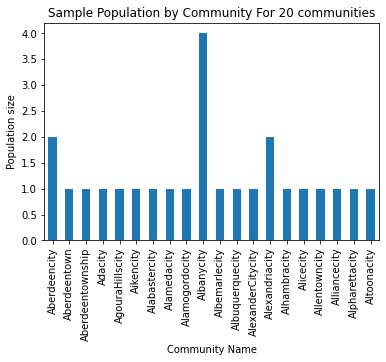

In [3]:
# Community analysis
print(f"Number of Unique communities: {train_df['communityname'].nunique()}")
# Visualize 
train_df.groupby('communityname')['population'].count()[:20].plot(kind='bar')
plt.title("Sample Population by Community For 20 communities")
plt.xlabel("Community Name")
plt.ylabel("Population size")
plt.savefig("poppercomm.png")

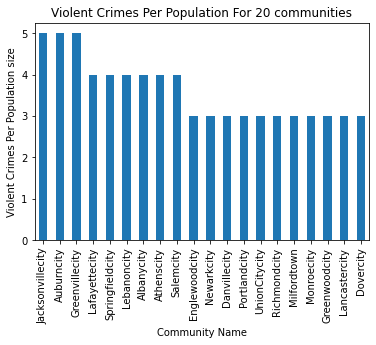

In [4]:
train_df.groupby('communityname')['ViolentCrimesPerPop'].count().sort_values(ascending=False)[:20].plot(kind='bar')
plt.title("Violent Crimes Per Population For 20 communities")
plt.xlabel("Community Name")
plt.ylabel("Violent Crimes Per Population size")
plt.savefig("violentcrimebypop.png")

1    1250
0     743
Name: crime_rate, dtype: int64


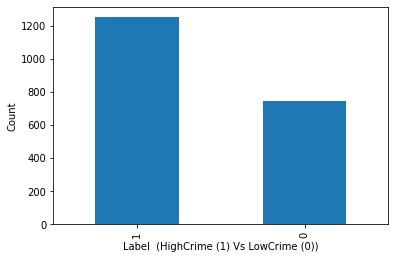

In [5]:
# Creating the target variable
train_df['crime_rate'] = np.where(train_df['ViolentCrimesPerPop']>0.1, 1, 0)

# crime rate counts. 0 - low crime rate, 1- high crime rate
print(train_df['crime_rate'].value_counts())
train_df['crime_rate'].value_counts().plot(kind='bar')
plt.xlabel("Label  (HighCrime (1) Vs LowCrime (0))")
plt.ylabel("Count")
plt.savefig("crimerate.png")

### Modeling

In [6]:
target = np.array(train_df['crime_rate'])
drop_columns = ['ViolentCrimesPerPop', 'crime_rate', 'fold', 'communityname', 'state']
features = train_df.drop(drop_columns, axis=1).reset_index(drop=True).values

### Xgboost Model For Crime Rate Prediction

In [7]:
%%time
xgb_model = xgb.XGBClassifier(max_depth=7,
                              n_estimators=200,
                              colsample_bytree=0.9, 
                              subsample=0.9,
                              nthread=2,
                              eval_metric='auc',
                              learning_rate=0.145,
                              random_state=42,
                              n_jobs=-1
                             )
kfold = KFold(n_splits=4)
acc = []
for i, (train, val) in enumerate(kfold.split(features, target), 1):
    X_train, y_train = features[train], target[train]
    X_test, y_test = features[val], target[val]
    xgb_model.fit(X_train, y_train)
    test_preds = xgb_model.predict(X_test)
    score = accuracy_score(y_test, test_preds)
    acc.append(score)
    print(f'Fold-{i} test accuracy: {score}')
print(f'Mean test accuracy over 4 folds: {np.mean(acc)}')

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Fold-1 test accuracy: 0.843687374749499
Fold-2 test accuracy: 0.7610441767068273
Fold-3 test accuracy: 0.821285140562249
Fold-4 test accuracy: 0.821285140562249
Mean test accuracy over 4 folds: 0.8118254581452061
CPU times: user 10.3 s, sys: 42 ms, total: 10.3 s
Wall time: 5.26 s


### LightGBM Model For Crime Rate Prediction

In [8]:
# LightGBM model
lgbm_params = {'objective': 'binary',
               'metric' : 'auc',   
               'learning_rate': 0.035,
               'max_depth': 7,
               'num_leaves': 64, 
               'feature_fraction': 0.9,
               'bagging_fraction': 0.9,
               'n_estimators':150,
               'random_state': 42,
               'max_bin': 500
               }

lgbm_model = lgbm.LGBMClassifier(**lgbm_params)

kfold = KFold(n_splits=4)
l_acc = []
for i, (train, val) in enumerate(kfold.split(features, target), 1):
    X_train, y_train = features[train], target[train]
    X_test, y_test = features[val], target[val]
    lgbm_model.fit(X_train, y_train,
                   eval_set=[(X_train, y_train), (X_test, y_test)],
                   eval_metric='auc',
                   early_stopping_rounds=20
                   )
    test_preds = lgbm_model.predict(X_test)
    score = accuracy_score(y_test, test_preds)
    l_acc.append(score)
    print(f'Fold-{i} test accuracy: {score}')
print(f'Mean LGBM test accuracy over 4 folds: {np.mean(acc)}')


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[1]	training's auc: 0.936751	valid_1's auc: 0.865178
Training until validation scores don't improve for 20 rounds
[2]	training's auc: 0.949037	valid_1's auc: 0.884392
[3]	training's auc: 0.952398	valid_1's auc: 0.887829
[4]	training's auc: 0.959236	valid_1's auc: 0.893181
[5]	training's auc: 0.958941	valid_1's auc: 0.89779
[6]	training's auc: 0.959491	valid_1's auc: 0.898567
[7]	training's auc: 0.961483	valid_1's auc: 0.900669
[8]	training's auc: 0.962845	valid_1's auc: 0.90147
[9]	training's auc: 0.964144	valid_1's auc: 0.904024
[10]	training's auc: 0.965644	valid_1's auc: 0.902619
[11]	training's auc: 0.967827	valid_1's auc: 0.905022
[12]	training's auc: 0.968705	valid_1's auc: 0.907507
[13]	training's auc: 0.968949	valid_1's auc: 0.90789
[14]	tra

### ANN For Crime Rate Prediction

In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Splitting the data into train and test for the NN model.
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=42
                                                   )

In [22]:
## NN
model = models.Sequential()
model.add(layers.Dense(512,input_shape=(X_train.shape[1],)))
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))
model.summary()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               51712     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 224,257
Trainable params: 224,257
Non-trainable params: 0
_________________________________________________________________


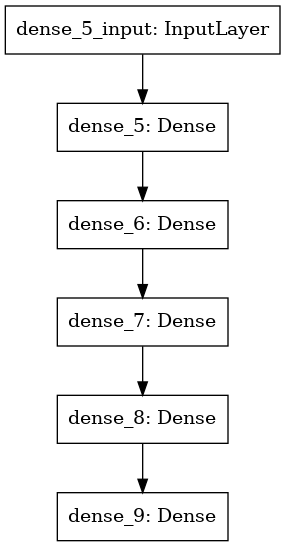

In [23]:
tf.keras.utils.plot_model(model, to_file='model.png')

In [24]:
history = model.fit(X_train, y_train,
                    batch_size=8,
                    epochs=8,
                    verbose=2,
                    validation_data=(X_test, y_test)
                   )

Epoch 1/8
200/200 - 1s - loss: 0.4444 - accuracy: 0.7911 - val_loss: 0.3846 - val_accuracy: 0.8221
Epoch 2/8
200/200 - 0s - loss: 0.3927 - accuracy: 0.8181 - val_loss: 0.3347 - val_accuracy: 0.8471
Epoch 3/8
200/200 - 0s - loss: 0.3831 - accuracy: 0.8187 - val_loss: 0.3425 - val_accuracy: 0.8296
Epoch 4/8
200/200 - 0s - loss: 0.3777 - accuracy: 0.8256 - val_loss: 0.3489 - val_accuracy: 0.8521
Epoch 5/8
200/200 - 0s - loss: 0.3705 - accuracy: 0.8300 - val_loss: 0.3288 - val_accuracy: 0.8471
Epoch 6/8
200/200 - 0s - loss: 0.3698 - accuracy: 0.8275 - val_loss: 0.3266 - val_accuracy: 0.8571
Epoch 7/8
200/200 - 0s - loss: 0.3711 - accuracy: 0.8312 - val_loss: 0.3331 - val_accuracy: 0.8546
Epoch 8/8
200/200 - 0s - loss: 0.3614 - accuracy: 0.8319 - val_loss: 0.3255 - val_accuracy: 0.8622


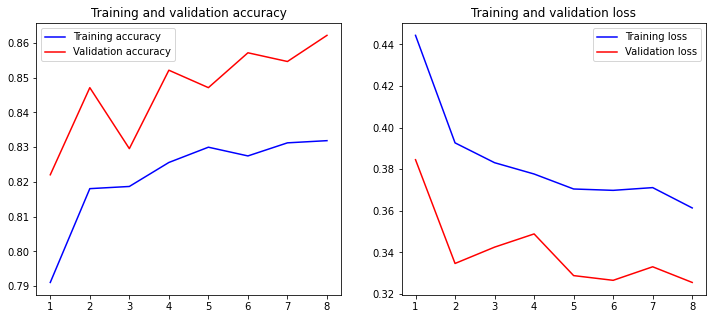

In [25]:
# Loss curves
def plot_history(history):
    accuracy = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training accuracy')
    plt.plot(x, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.savefig('score.png')
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.savefig('loss.png')

plot_history(history)

In [26]:
mean_accuracy = np.mean(history.history['val_accuracy'])
print(f"Average accuracy over 8 epochs: {mean_accuracy}")

Average accuracy over 8 epochs: 0.8464912325143814


In [ ]:
## References:
    # https://www.kaggle.com/dhawalsoni/sanfran
    # https://github.com/tina31726/Crime-Prediction/